## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import  Image,ImageDraw,ImageFont
%matplotlib qt


## 1) Calibrate the Camera

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    nx = 9
    ny = 6
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None) # 找到corners

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

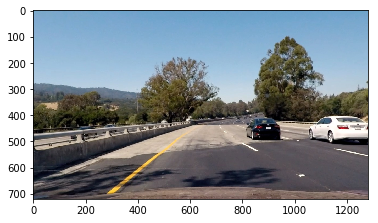

In [4]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    #undist = np.copy(img)  # Delete this line
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist 

def cal_undistort_video(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    #undist = np.copy(img)  # Delete this line
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist,ret, mtx, dist, rvecs, tvecs 

test_img = mpimg.imread('test_images/test4.jpg') # Pick one test pic as example

test_undist = cal_undistort(test_img, objpoints, imgpoints)
test_undist_2,ret, mtx, dist, rvecs, tvecs = cal_undistort_video(test_img, objpoints, imgpoints)
plt.imshow(test_undist)

## 2) Create Binary Image

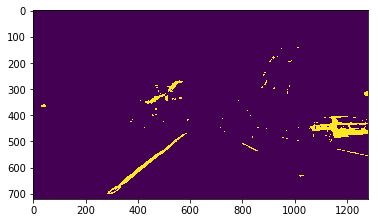

In [5]:
def binary_tf(img, s_thresh=(180, 255), sx_thresh=(100, 150), l_thresh =(225, 255),b_thresh =(225, 255)):
    img = np.copy(img)
    ## Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    ## Light color Channel
    #l_binary = np.zeros_like(l_channel)
    #l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    ## LUV
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV) #白色 White
    l_channel2 = luv[:,:,0]
    l_binary = np.zeros_like(l_channel2)
    l_binary[(l_channel2 >= l_thresh[0]) & (l_channel2 <= l_thresh[1])] = 1
    
    ## LAB
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB) #黄色 Yellow
    b_channel = lab[:,:,2]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1  
    
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, l_binary)) * 255 #??
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1)&(sxbinary == 1)|(l_binary == 1)|(b_binary == 1)] = 1
    
    return combined_binary

test_binary = binary_tf(test_undist, s_thresh=(180, 230), sx_thresh=(120, 200), l_thresh =(225, 255), b_thresh =(155, 200))
plt.imshow(test_binary)

#plt.savefig('binary.png')

## 4) Perspective Transform

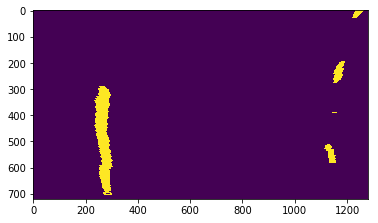

In [6]:
def perspective_tf(img):
    src = np.float32([[250,705],[1155,705],[805,505],[530,505]])
    dst = np.float32([[250,705],[1155,705],[1155,505],[250,505]])   
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR) 
    
    #Remove the point in the end of route 涂黑，避免影响
    warped[0:100,0:warped.shape[0]] = 0
    warped[0:warped.shape[1],0:180] = 0
    return warped,M

test_persp,M = perspective_tf(test_binary)
plt.imshow(test_persp)
#plt.savefig('persp.png')

## 5.1) Find Lane Boundary

In [7]:
def find_lane_pixels(test_persp):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(test_persp[test_persp.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((test_persp, test_persp, test_persp))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(test_persp.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = test_persp.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = test_persp.shape[0] - (window+1)*window_height
        win_y_high = test_persp.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

#leftx, lefty, rightx, righty, out_img = find_lane_pixels(test_persp)
#plt.imshow(out_img)
#plt.savefig('lane_pixel.png')


## 5.2) fit the lanes from pixels

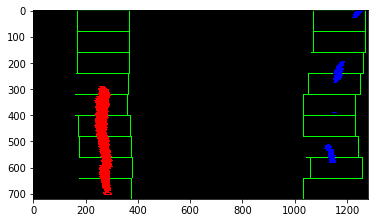

In [8]:
def fit_polynomial(test_persp):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(test_persp)
    ploty = np.linspace(0, test_persp.shape[0]-1, test_persp.shape[0] )
    if len(lefty)==0 or len(righty)==0 or len(leftx)==0 or len(rightx)==0: # In Case this is no point found
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    else:
    # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)  # 拟合曲线的系数
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
  
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty
        ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.figure(3) 
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.close(3) # close the figure, if want to see the figure, pls open this     

    return out_img,left_fitx, right_fitx, ploty # left_fitx和right_fitx是拟合出的曲线


test_boundline,left_fitx, right_fitx,ploty = fit_polynomial(test_persp)

plt.imshow(test_boundline)
#plt.savefig('test_boundline.png')

## 6) Calculate the Curvature

In [9]:
def process_data(leftx, rightx,test_persp):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/875 # meters per pixel in x dimension
    # Fit a second order polynomial to pixel positions in each fake lane line
    ##### TO-DO: Fit new polynomials to x,y in world space #####
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    ploty_left = np.linspace(0, test_persp.shape[0]-1, len(leftx) )*ym_per_pix
    ploty_right = np.linspace(0, test_persp.shape[0]-1, len(rightx) )*ym_per_pix
    leftx = leftx*xm_per_pix
    rightx = rightx*xm_per_pix
    if len(leftx)==0 or len(rightx)==0: # In Case this is no point found
        ploty_left = 0
        ploty_right = 0
        left_fit_cr = [1,1]
        right_fit_cr = [1,1]
    else:
        left_fit_cr = np.polyfit(ploty_left, leftx, 2)
        right_fit_cr = np.polyfit(ploty_right, rightx, 2)
    
    return  ploty_left,ploty_right, left_fit_cr, right_fit_cr

    
def measure_curvature_real(ploty_left,ploty_right, left_fit_cr, right_fit_cr):
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(ploty_left) + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(ploty_right) + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0]) ## Implement the calculation of the right line here
    final_curverad = (left_curverad+right_curverad)/2
    return final_curverad
# Calculate the radius of curvature in meters for both lane lines

leftx, lefty, rightx, righty, out_img = find_lane_pixels(test_persp)
ploty_left,ploty_right, left_fit_cr, right_fit_cr = process_data(leftx, rightx, test_persp)
final_curverad = measure_curvature_real(ploty_left,ploty_right, left_fit_cr, right_fit_cr)

print('%.2f'%(final_curverad),'m')



1925.44 m


### Question: <font color=coral >why leftx and rightx are different length? -> lead ploty should be two length </font>

## 7) Plot the lane on the original picture

In [10]:
def plot_area(test_undist,test_persp,M,final_curverad):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(test_persp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
   # plt.figure(1)
   # plt.imshow(color_warp)

    # Recast the x and y points into usable format for cv2.fillPoly()
    ym_per_pix = 30/720
   # ploty= np.linspace(0, test_undist.shape[0]-1, test_indist.shape[0] )*ym_per_pix
    test_boundline,left_fitx, right_fitx,ploty = fit_polynomial(test_persp)
    left_lane_end = left_fitx[-1]
    right_lane_end = right_fitx[-1]
    lane_center = left_lane_end + (right_lane_end - left_lane_end)/2
    vehicle_center = test_undist.shape[1]/2
    error = (lane_center - vehicle_center)*3.7/(test_persp.shape[1]*0.9)
    
    
   # plt.figure(2)
    #plt.imshow(test_boundline)
   # print(left_fitx)
   # print(ploty)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))  #填充绿色
    #cv2.polylines(color_warp, np.int_([left_fitx[:],ploty[:]]), True, (0, 0, 255), 10)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='purple')
    #pic = plt.figure(10)
    
   # plt.figure(2)
   # plt.imshow(color_warp)
    Minv = np.mat(M).I # the inverse of Perspective Matrix
    newwarp = cv2.warpPerspective(color_warp, Minv,(test_undist.shape[1], test_undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(test_undist, 1, newwarp, 0.5, 0)
    
    # Plot the number on the final output
    ttfont = ImageFont.truetype("C:\Windows\Fonts\Arial.ttf",20) 
    final_pic_r = Image.fromarray(result.astype(np.uint8))
    draw = ImageDraw.Draw(final_pic_r)
    x,y=(500,50)
    string = "numerical estimation of lane curvature is %.2f"%(final_curverad)+"m"+"\n vehicle position is  %.2f" %(error)+"m left to the middle"
    draw.text((x,y), string, font=ttfont)
    #final_pic_r.show()   
    final_ouput = np.array(final_pic_r, dtype = np.uint8)

    return final_ouput,error

## Example: Process the Picture

0.27 m


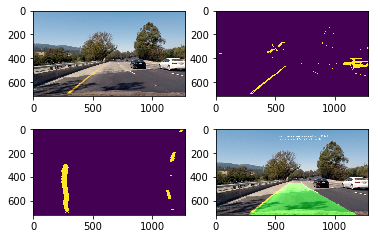

In [11]:
# Main Process
plt.clf() # close all the figure
test_img = mpimg.imread('test_images/test4.jpg') # Pick one test pic as example

test_undist = cal_undistort(test_img, objpoints, imgpoints)
#plt.figure(1)
#plt.imshow(test_undist)

test_binary = binary_tf(test_undist,s_thresh=(180, 230), sx_thresh=(120, 200), l_thresh =(225, 255), b_thresh =(155, 200))
# 调整参数
#plt.figure(2)
#plt.imshow(test_binary)

test_persp,M = perspective_tf(test_binary)
#plt.figure(3)
#plt.imshow(test_persp)

test_boundline,left_fitx, right_fitx,ploty = fit_polynomial(test_persp)
#给透视图再加一点处理，让上半部分涂黑，规避影响
#plt.figure(4)
#plt.imshow(test_boundline)

leftx, lefty, rightx, righty, out_img = find_lane_pixels(test_persp)
ploty_left,ploty_right, left_fit_cr, right_fit_cr = process_data(leftx, rightx, test_persp)
final_curverad = measure_curvature_real(ploty_left,ploty_right, left_fit_cr, right_fit_cr)


final_pic,error = plot_area(test_undist,test_persp,M,final_curverad)

plt.figure(1)
plt.subplot(221)
plt.imshow(test_undist)
plt.subplot(222)
plt.imshow(test_binary)
plt.subplot(223)
plt.imshow(test_persp)
plt.subplot(224)
plt.imshow(final_pic)

print("%.2f"%error, 'm')
plt.savefig('example.png')

#plt.figure(2)
#plt.imshow(final_pic)
#plt.savefig('example_2.png')


## Pipeline for Process

In [12]:
def process_image(image):
    test_img = np.copy(image)
    test_undist = cv2.undistort(test_img, mtx, dist, None, mtx)
    test_binary = binary_tf(test_undist, s_thresh=(180, 230), sx_thresh=(120, 200), l_thresh =(225, 255), b_thresh =(155, 200))
    test_persp,M = perspective_tf(test_binary)

    test_boundline,left_fitx, right_fitx,ploty = fit_polynomial(test_persp)

    leftx, lefty, rightx, righty, out_img = find_lane_pixels(test_persp)
    ploty_left,ploty_right, left_fit_cr, right_fit_cr = process_data(leftx, rightx, test_persp)
    final_curverad = measure_curvature_real(ploty_left,ploty_right, left_fit_cr, right_fit_cr)
    
    final_pic,error = plot_area(test_undist,test_persp,M,final_curverad)
    
    return final_pic

## Example: Process the video

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#white_output = 'test_videos_output/solidWhiteRight.mp4'
white_output = 'project_video_output.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:51<00:00,  5.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 3min 51s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>white_output
""".format(white_output))